# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [5]:
X.shape, y.shape

((13150, 9), (13150,))

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

### Se define la función para calcular indice de Gini de los datos de entrada

In [6]:
def gini(y):
  if y.shape[0] == 0:
    return 0
  else:
    return 1 - (y.mean()**2 + (1 - y.mean())**2)

### Se define la función para calcular la ganancia de una división k en la característica j

In [7]:
def gini_impurity(X_col, y, split):
  "Calculate the gain of an split k on feature j"
  
  filter_l = X_col < split
  y_l = y.loc[filter_l]
  y_r = y.loc[~filter_l]
      
  n_l = y_l.shape[0]
  n_r = y_r.shape[0]
    
  gini_y = gini(y)
  gini_l = gini(y_l)
  gini_r = gini(y_r)
  
  gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
  
  return gini_impurity_

### Se define la funcion para seleccionar el mejor split

In [8]:
def best_split(X, y, num_pct=10):
  
  features = range(X.shape[1])
  
  best_split = [0, 0, 0]  # j, split, gain
  
  # For all features
  for j in features:
    splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
    splits = np.unique(splits)[1:]
    
    # For all splits
    for split in splits:
      gain = gini_impurity(X.iloc[:, j], y, split)
      
      if gain > best_split[2]:
        best_split = [j, split, gain]
  
  return best_split

### Se define la función para crear el arbol

In [9]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
  
  # If only one observation
  if X.shape[0] == 1:
    tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
    return tree
  
  # Calculate the best split
  j, split, gain = best_split(X, y, num_pct)
  # save tree and estimate prediction
  y_pred = int(y.mean() >= 0.5) 
  y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
  
  tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
  
  # Check stooping criteria
  if gain < min_gain:
    return tree
  if max_depth is not None:
    if level >= max_depth:
      return tree
  
  # No stooping criteria was meet, then continue to create the partition
  filter_l = X.iloc[:, j] < split
  X_l, y_l = X.loc[filter_l], y.loc[filter_l]
  X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
  tree['split'] = [j, split]
  
  # Next iteration to each split
  tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
  tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
  return tree

### Se define la función para realizar las predicciones a partir de un Arbol

In [10]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [11]:
tree=tree_grow(X_train, y_train, level=1, min_gain=0.001, max_depth=3, num_pct=10)

In [12]:
df = pd.DataFrame({'real':y_test, 'pred':tree_predict(X_test, tree)})
df

,real,pred
332784,1,0.0
146436,1,1.0
130476,1,1.0
85618,1,1.0
75474,0,0.0
330419,0,0.0
205915,1,1.0
2836,0,0.0
250833,1,1.0
126784,0,0.0


In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(df.real,df.pred)

0.8610599078341014

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

#### Bagging is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for bootstrap aggregation, meaning the aggregation of bootstrap samples.

In [14]:
# set a seed for reproducibility - Crea la semilla
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [15]:
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

In [16]:
for i, sample in enumerate(samples):
    X_train2 = X_train.iloc[sample,]
    y_train2 = y_train.iloc[sample,]
    tree=tree_grow(X_train2, y_train2, level=1, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred[i]=tree_predict(X_test, tree) 

In [17]:
acc=0
for i in range(n_B):
    print(i, accuracy_score(y_pred[i], y_test))
    acc += accuracy_score(y_pred[i], y_test)


0 0.8428571428571429
1 0.8610599078341014
2 0.8608294930875576
3 0.8403225806451613
4 0.8624423963133641
5 0.8610599078341014
6 0.8629032258064516
7 0.8617511520737328
8 0.8675115207373272
9 0.8619815668202765


In [18]:
acc/n_B 

0.8582718894009218

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

#### Se redefine la función best_split, adicionandole un parametro llamado max_features, el cual servira para seleccionar de manera aleatoria las features para realizar el split.

In [19]:
def best_split_mf(X, y, num_pct=10,max_features=10):
    from random import shuffle
    
    #Aqui se incluye instruccion para tomar de manera aleatoria un numero maximo indicado de features
    #a tener en cuenta para hacer el split.
    cols = list(X.columns.values)
    shuffle(cols)
    X = X[cols[:max_features]]
        
    features = range(X.shape[1])
    print (features)
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
    
    # For all splits
    for split in splits:
        gain = gini_impurity(X.iloc[:, j], y, split)
    
    
    if gain > best_split[2]:
        best_split = [j, split, gain]
    
    
    return best_split

#### Se redefine la función tree_grow, adicionandole el parametro max_features, el cual servira para llamar la funcion best_split_mf (creada en el bloque anterior).

In [20]:
def tree_grow_mf(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=10):
  
  # If only one observation
  if X.shape[0] == 1:
    tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
    return tree
  
  # Calculate the best split
  j, split, gain = best_split_mf(X, y, num_pct, max_features)
  # save tree and estimate prediction
  y_pred = int(y.mean() >= 0.5) 
  y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
  
  tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
  
  # Check stooping criteria
  if gain < min_gain:
    return tree
  if max_depth is not None:
    if level >= max_depth:
      return tree
  
  # No stooping criteria was meet, then continue to create the partition
  filter_l = X.iloc[:, j] < split
  X_l, y_l = X.loc[filter_l], y.loc[filter_l]
  X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
  tree['split'] = [j, split]
  
  # Next iteration to each split
  tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
  tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
  return tree



# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [ ]:
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

max_features = int(np.log((X_train.shape[1])))

for i, sample in enumerate(samples):
    X_train2 = X_train.iloc[sample,]
    y_train2 = y_train.iloc[sample,]
    tree=tree_grow_mf(X_train2, y_train2, level=1, min_gain=0.001, max_depth=3, num_pct=10,max_features=max_features)
    y_pred[i]=tree_predict(X_test, tree) 

acc=0

for i in range(n_B):
    print(i, accuracy_score(y_pred[i], y_test))
    acc += accuracy_score(y_pred[i], y_test)    

print('Promedio:',acc/n_B)

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)

In [22]:
from sklearn.model_selection import cross_val_score
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()


count    10.000000
mean      0.841062
std       0.012698
min       0.823440
25%       0.833080
50%       0.838023
75%       0.847148
max       0.866160
dtype: float64

In [23]:
estimator_range = range(5, 350, 10)
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

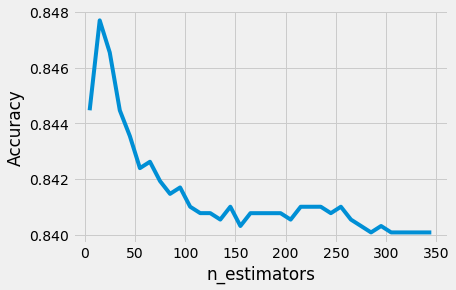

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [25]:
feature_cols = X.columns

# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

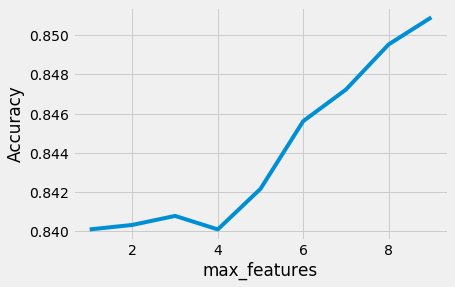

In [26]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [27]:
# max_features=9 is best and n_estimators=20 is sufficiently large
clf = RandomForestClassifier(n_estimators=20, max_features=9, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')


,feature,importance
4,M_CamryBase,0.000043
3,M_Camry4dr,0.001160
5,M_CamryL,0.005806
7,M_CamrySE,0.007151
2,M_Camry,0.009221
8,M_CamryXLE,0.010034
6,M_CamryLE,0.015031
0,Year,0.113574
1,Mileage,0.837980


#### Se calcula el Accuraccy con el set de pruebas

In [28]:
 accuracy_score(clf.predict(X_test) , y_test) 

0.8483870967741935